In [1]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 19.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2746706 sha256=626d904b3eba55f869b5fbed81641cd47034f1df1ad94025fc41d569bd2ff85d
  Stored in directory: /root/.cache/pip/wheels/8d/df/d6/88ce619bde055ebffebae5380645802eca490817853b60b45b
Successfully built pyedflib
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import neurokit2 as nk
import json
import os
# import wfdb
import pickle
import random
from scipy.signal import find_peaks
import mne
import pyedflib
from tqdm import tqdm
from scipy.signal import butter, filtfilt

In [5]:
def read_edf_record(file_path):
    try:
        f = pyedflib.EdfReader(file_path)
        n_channels = f.signals_in_file
        channel_labels = f.getSignalLabels()
        signals = np.vstack([f.readSignal(i) for i in range(n_channels)])
        sfreq = f.getSampleFrequency(0)
        f._close()
        return signals, channel_labels, sfreq
    except Exception as e:
        print(f"Ошибка при чтении {file_path}: {e}")
        return None, None, None

def extract_periods(signal, sfreq, num_periods=1, distance_sec=0.6):
    peaks, _ = find_peaks(signal, distance=int(distance_sec * sfreq * 0.8))
    if len(peaks) < num_periods + 1:
        raise ValueError("Недостаточно пиков")
    periods = []
    for i in range(num_periods):
        start = peaks[i]
        end = peaks[i+1]
        half = int((end-start)/2)
        periods.append(signal[end-half:end+half])
    return periods

def process_record(record_path, target_channels):
    signals, channel_labels, sfreq = read_edf_record(record_path) 
    lowcut = 0.6  
    highcut = 40
    order = 1  
    nyquist_freq = 0.5 * sfreq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    
    if signals is None or channel_labels is None:
        print(f"❌ Пропуск: {record_path} — сигналы не загружены")
        return None
    if not all(ch in channel_labels for ch in target_channels):
        print(f"❌ Пропуск: {record_path} — отсутствуют каналы: {[ch for ch in target_channels if ch not in channel_labels]}")
        return None
    if signals is None or channel_labels is None:
        return None
    if not all(ch in channel_labels for ch in target_channels):
        return None
    ecg_pieces = []
    for ch in target_channels:
        idx = channel_labels.index(ch)
        # print(f'channel = {ch}, index = {idx}')
        ch_data = signals[idx]
        # ch_data = (ch_data - np.mean(ch_data)) / np.std(ch_data)
        b, a = butter(order, [low, high], btype='bandpass')
        ch_dat = filtfilt(b, a, ch_data)
        try:
            periods = extract_periods(ch_dat, sfreq, num_periods=1)
            ecg_pieces.append(periods[0])
        except Exception as e:
            print(f"Ошибка: {e}")
            return None
    return np.hstack(ecg_pieces).tolist()

In [6]:
mne.set_log_level('WARNING')

base_folder = '/kaggle/input/low-ejection-fraction'
edf_folders = [f'{i}/{i}' for i in range(1, 12)]
target_channels = ['ECG I', 'ECG II', 'ECG V1', 'ECG V2', 'ECG V3', 'ECG V4', 'ECG V5', 'ECG V6']

# Читаем lef_names.csv (без заголовка)
lef_df = pd.read_csv(f'{base_folder}/lef_names.csv', header=None)
lef_names = set(lef_df[0].apply(lambda x: os.path.splitext(os.path.basename(str(x).strip()))[0]))
print("Колво строк в lef_names.csv:", len(lef_names))

# Собираем все .edf файлы
record_paths = dict()
for folder in edf_folders:
    folder_path = os.path.join(base_folder, folder)
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.edf'):
                name = os.path.splitext(file)[0]
                record_paths[name] = os.path.join(root, file)

print(f"Найдено .edf файлов: {len(record_paths)}")
print("Примеры:", list(record_paths.items())[:5])

all_records = list(record_paths.keys())

# Делим на положительные и оставшиеся
pos_names = list(lef_names & set(all_records))
print(f"Положительных файлов, найденных среди всех: {len(pos_names)}")
neg_candidates = list(set(all_records) - lef_names)
random.shuffle(neg_candidates)
neg_names = neg_candidates[:len(pos_names)]

used_names = set(pos_names + neg_names)
remaining_names = list(set(all_records) - used_names)

# Обработка и сбор
tune_data = []
tune_labels = []
tune_files_pos = []
tune_files_neg = []

print("🔄 Обработка ecg_tune.pkl...")
for name, label in tqdm([(n, 1) for n in pos_names] + [(n, 0) for n in neg_names]):
    sig = process_record(record_paths[name], target_channels)
    if sig:
        tune_data.append(sig)
        tune_labels.append(label)
        if label == 1:
            tune_files_pos.append(name)
        else:
            tune_files_neg.append(name)

df_tune = pd.DataFrame({'signal': tune_data, 'label': tune_labels})
with open('ecg_tune.pkl', 'wb') as f:
    pickle.dump(df_tune, f)

# Обработка оставшихся
print("🔄 Обработка ecg_data.pkl...")
data_data = []
data_files = []
for name in tqdm(remaining_names):
    sig = process_record(record_paths[name], target_channels)
    if sig:
        data_data.append(sig)
        data_files.append(name)

df_data = pd.DataFrame({'signal': data_data})
with open('ecg_data.pkl', 'wb') as f:
    pickle.dump(df_data, f)

# Вывод результатов
print(f"\n✅ ecg_tune.pkl: {len(tune_data)} записей (положит: {len(tune_files_pos)}, отрицат: {len(tune_files_neg)})")
print(f"Примеры положительных: {tune_files_pos[:5]}")
print(f"Примеры отрицательных: {tune_files_neg[:5]}")
print(f"\n✅ ecg_data.pkl: {len(data_data)} записей")
print(f"Примеры оставшихся: {data_files[:5]}")


Колво строк в lef_names.csv: 908
Найдено .edf файлов: 10795
Примеры: [('TG249', '/kaggle/input/low-ejection-fraction/1/1/TG249.edf'), ('TG919', '/kaggle/input/low-ejection-fraction/1/1/TG919.edf'), ('TG405', '/kaggle/input/low-ejection-fraction/1/1/TG405.edf'), ('TG318', '/kaggle/input/low-ejection-fraction/1/1/TG318.edf'), ('TG438', '/kaggle/input/low-ejection-fraction/1/1/TG438.edf')]
Положительных файлов, найденных среди всех: 908
🔄 Обработка ecg_tune.pkl...


100%|██████████| 1816/1816 [00:46<00:00, 38.77it/s]


🔄 Обработка ecg_data.pkl...


100%|██████████| 8979/8979 [03:53<00:00, 38.46it/s]



✅ ecg_tune.pkl: 1816 записей (положит: 908, отрицат: 908)
Примеры положительных: ['TG8007', 'TG4733', 'TG6850', 'TG7892', 'TG224']
Примеры отрицательных: ['TG8879', 'TG6584', 'TG6191', 'TG4982', 'TG10523']

✅ ecg_data.pkl: 8979 записей
Примеры оставшихся: ['TG6502', 'TG5006', 'TG3515', 'TG8727', 'TG8851']


In [7]:
import wfdb

base_folder = '/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500'
physionet_folders = ['00000', '01000', '02000', '03000', '04000', '05000', '06000', '07000', '08000', '09000']
target_channels_physio = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def read_physionet_record(record_path):
    try:
        record = wfdb.rdrecord(record_path)
        channel_labels = record.sig_name
        signals = record.p_signal.T  # транспонируем, чтобы было [n_channels, n_samples]
        sfreq = record.fs
        return signals, channel_labels, sfreq
    except Exception as e:
        print(f"Ошибка при чтении {record_path}: {e}")
        return None, None, None

def process_physio_record(record_path, target_channels):
    signals, channel_labels, sfreq = read_physionet_record(record_path)
    lowcut = 0.6  
    highcut = 40
    order = 1  
    nyquist_freq = 0.5 * sfreq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq

    if signals is None or channel_labels is None:
        print(f"❌ Пропуск: {record_path} — сигналы не загружены")
        return None
    if not all(ch in channel_labels for ch in target_channels):
        print(f"❌ Пропуск: {record_path} — отсутствуют каналы: {[ch for ch in target_channels if ch not in channel_labels]}")
        return None
    ecg_pieces = []
    for ch in target_channels:
        idx = channel_labels.index(ch)
        ch_data = signals[idx]
        b, a = butter(order, [low, high], btype='bandpass')
        ch_dat = filtfilt(b, a, ch_data)
        try:
            periods = extract_periods(ch_dat, sfreq, num_periods=1)
            ecg_pieces.append(periods[0])
        except Exception as e:
            print(f"Ошибка: {e}")
            return None
    return np.hstack(ecg_pieces).tolist()

# Сбор путей к .dat/.hea
physio_record_paths = dict()
for folder in physionet_folders:
    folder_path = os.path.join(base_folder, folder)
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.hea'):
                name = os.path.splitext(file)[0]
                physio_record_paths[name] = os.path.join(root, name)

print(f"Найдено physio-файлов: {len(physio_record_paths)}")
print("Примеры:", list(physio_record_paths.items())[:5])

# Обработка physio данных
physio_data = []
physio_files = []
print("🔄 Обработка physio данных...")
for name, path in tqdm(physio_record_paths.items()):
    sig = process_physio_record(path, target_channels_physio)
    if sig:
        physio_data.append(sig)
        physio_files.append(name)

df_physio = pd.DataFrame({'signal': physio_data})
print(f"\n✅ df_physio: {len(df_physio)} записей")
print(f"Примеры: {physio_files[:5]}")

# Объединение с df_data (из EDF)
df_data_combined = pd.concat([df_data, df_physio], ignore_index=True)

with open('ecg_data_combined.pkl', 'wb') as f:
    pickle.dump(df_data_combined, f)

print(f"\n✅ ecg_data_combined.pkl: {len(df_data_combined)} записей")


Найдено physio-файлов: 9999
Примеры: [('00848_hr', '/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/00000/00848_hr'), ('00980_hr', '/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/00000/00980_hr'), ('00706_hr', '/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/00000/00706_hr'), ('00540_hr', '/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/00000/00540_hr'), ('00173_hr', '/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/00000/00173_hr')]
🔄 Обработка physio данных...


100%|██████████| 9999/9999 [03:12<00:00, 51.91it/s]



✅ df_physio: 9999 записей
Примеры: ['00848_hr', '00980_hr', '00706_hr', '00540_hr', '00173_hr']

✅ ecg_data_combined.pkl: 18978 записей


In [8]:
# df_tune.to_pickle('ecg_tune.pkl')
# df_data.to_pickle('ecg_data.pkl')

In [9]:
# df = pd.read_csv('ecg_data.csv')
df = df_data_combined
print(df.shape)
df.head(5)

(18978, 1)


,signal
0,"[-0.058704504644863355, -0.05736539394872103, ..."
1,"[-0.019705819927583863, -0.019619104832058386,..."
2,"[0.008350811259904469, 0.013407213308988884, 0..."
3,"[-0.0036969810607958096, -0.005725953351661902..."
4,"[0.16504100527617718, 0.17047389279891065, 0.1..."


/tmp/ipykernel_19/2147779955.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = np.linspace(0, 100, len(df.iloc[2000][0]))
/tmp/ipykernel_19/2147779955.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(n, df.iloc[2000][0])


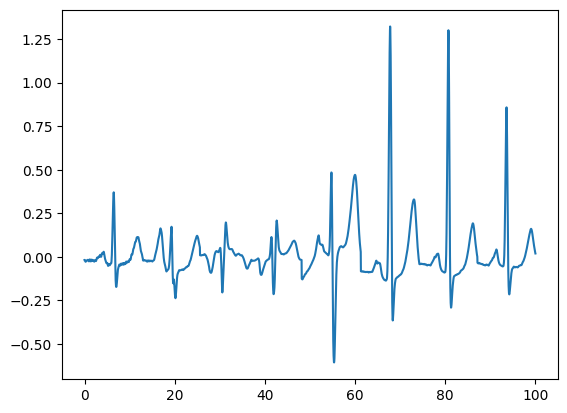

In [10]:
n = np.linspace(0, 100, len(df.iloc[2000][0]))
plt.plot(n, df.iloc[2000][0])

In [11]:
len(df.iloc[11000][0])

/tmp/ipykernel_19/4145123518.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  len(df.iloc[11000][0])


2582

In [12]:
def resample_signal(row):
    original_signal = row['signal']
    resampled_signal = nk.signal_resample(original_signal, sampling_rate=500, desired_sampling_rate= 250, method="FFT")
    return pd.Series({'signal': resampled_signal})

In [13]:
total_db_new = df
resampled_df = total_db_new.apply(resample_signal, axis=1)
del total_db_new
total_db_new = resampled_df

In [14]:
len(total_db_new)

18978

In [15]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(total_db_new, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=(2/3), random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [16]:
def find_max_min(current_df):
  min_value = current_df['signal'].apply(lambda x: min(x)).min()
  max_value = current_df['signal'].apply(lambda x: max(x)).max()
  return min_value, max_value

min_train_df, max_train_df = find_max_min(train_df)
print(min_train_df, max_train_df)

min_val_df, max_val_df = find_max_min(val_df)
print(min_val_df, max_val_df)

min_test_df, max_test_df = find_max_min(test_df)
print(min_test_df, max_test_df)

-8.87892355685438 7.9680390132612
-6.179675942373771 4.646065113988147
-5.1322247790239715 7.547243807123167


In [17]:
train_df['signal'] = train_df['signal'].apply(lambda x: [(item - min_train_df) / (max_train_df - min_train_df) for item in x])

val_df['signal'] = val_df['signal'].apply(lambda x: [(item - min_val_df) / (max_val_df - min_val_df) for item in x])

test_df['signal'] = test_df['signal'].apply(lambda x: [(item - min_test_df) / (max_test_df - min_test_df) for item in x])

Quantizer

In [18]:
class DiffQuantizer:
    def __init__(self, alphabet_size, average_over=1, filter=False, breakpoints=None, use_diffs=True):

        self.alphabet_size = alphabet_size
        self.average_over = average_over
        self.use_filter = filter
        self.breakpoints = breakpoints
        self.use_diffs = use_diffs
        # print('self.breakpoints:',self.breakpoints)

    def preprocess(self, tmp):
        if self.average_over != 1:
            tmp = self._average_over_n(tmp, self.average_over)

        if self.use_filter:
            tmp = self._filter_signal(tmp)

        if self.use_diffs:
            tmp = self._diff_signal(tmp)

        return tmp

    def perform_quantization(self, tmp, breakpoints=None):
        self.breakpoints = breakpoints
        # print('perform_quantization, self.breakpoints:',self.breakpoints)
        tmp = self.preprocess(tmp)
        result = self._quantize_with_breakpoints(tmp)
        return result

    def learn_breakpoints(self, arr):
        res = self.preprocess(arr)

        sorted_array = np.sort(res)

        length = len(sorted_array)

        probs = [1 / self.alphabet_size for _ in range(self.alphabet_size)]
        cum_sum_breakpoints = [int(sum(probs[0:i + 1]) * length - 1) for i in range(len(probs))]
        cum_sum_breakpoint_values = sorted_array[cum_sum_breakpoints]

        cum_sum_breakpoint_values[-1] = 1e+100

        self.breakpoints = cum_sum_breakpoint_values
        # print('learn_breakpoints,self.breakpoints',self.breakpoints)

        return cum_sum_breakpoint_values

    # vectorized use
    @staticmethod
    def _breakpoint_to_letter(float_num, breakpoints):
        # print('float_num:',float_num,'breakpoints:',breakpoints)
        # print(list((breakpoints.index(obj) for obj in breakpoints if float_num < obj)))
        int_val = next((breakpoints.index(obj) for obj in breakpoints if float_num < obj))
        # print(int_val,list((breakpoints.index(obj) for obj in breakpoints if float_num < obj)))
        # A + int_val
        return chr(65 + int_val)

    def _quantize_with_breakpoints(self, tmp):
        breakpoints = self.breakpoints
        vect_breakpoint_to_letter = np.vectorize(self._breakpoint_to_letter, excluded=['breakpoints'])
        # print(tmp,breakpoints,self._breakpoint_to_letter,vect_breakpoint_to_letter)
        tmp = vect_breakpoint_to_letter(tmp, breakpoints=list(breakpoints))
        # tmp = vect_breakpoint_to_letter(tmp, breakpoints=breakpoints)
        return tmp

    @staticmethod
    def _read_csv_file(input_file):
        tmp_file_content = pd.read_csv(input_file, sep="\n", header=None, dtype=np.float64)
        return np.array(tmp_file_content)

    ## @staticmethod
    # def _filter_signal(tmp):
    #     return butter_lowpass_filter(tmp)

    @staticmethod
    def _average_over_n(tmp, n):
        return np.array([np.average(tmp[i:i + n]) for i in range(0, len(tmp), n)])

    @staticmethod
    def _diff_signal(tmp):
        res = np.diff(tmp)
        return np.insert(res, 0, 0.0)

In [19]:
import math
import csv

class Preprocessing():

  def __init__(self, input_file, discretizition_factor, max_window_size):
    self.input_file = input_file
    self.discretizition_factor = discretizition_factor
    self.max_window_size = max_window_size


  def create_window(self):

    ecg_window = [] #ecg_window: list of windows

    mlen=0
    ecg_list = self.input_file['signal']
    if len(ecg_list) > mlen:
      mlen= len(ecg_list)

    if mlen > self.max_window_size:
      window_size = self.max_window_size
    else:
      window_size = mlen

    num_lines = math.floor(len(ecg_list)/window_size) #in this case: 1

    for i in range(num_lines):
      tmp_list = ecg_list[i*window_size:(i+1)*window_size]
      ecg_window.append(tmp_list)

    return ecg_window

  def change_to_alphabet(self, quantizer, normalized_list):
    qtz_signal = []
    qtz = quantizer
    for i in range(len(normalized_list)): #i is for each line
      r = qtz.perform_quantization(np.array(normalized_list[i]),breakpoints=qtz.breakpoints)
      # print('result:',r.shape)
      # make r from list of chars  to string a chars by ''.joint(r)
      qtz_signal.append(''.join(r))

    return qtz_signal

In [20]:
def discretization_lloyd_max(discretizition_factor, total_data):
  qtz_signal = []
  qtz=DiffQuantizer(alphabet_size=discretizition_factor,breakpoints=None,use_diffs=False)
  qtz.learn_breakpoints(np.array(total_data))
  return qtz

In [21]:
def run_Preprocessing(db, max_window_size=4000, discretizition_factor=100):
    discretizition_factor = discretizition_factor
    max_window_size = max_window_size
    nl_list, total_data = [], []
    r_list = []

    for n in range(len(db)):
      pre = Preprocessing(db.loc[n], discretizition_factor, max_window_size)
      nl = pre.create_window()
      nl_list.append(nl)

    for i in range(len(nl_list)):
        total_data.extend(nl_list[i][0])

    quantize_max_lloyd_on_total_data = discretization_lloyd_max(discretizition_factor, total_data)

    for n in range(len(db)):
      pre = Preprocessing(db.loc[n], discretizition_factor, max_window_size)
      nl = pre.create_window()
      r = pre.change_to_alphabet(quantize_max_lloyd_on_total_data, nl)
      r_list.extend(r)
    print(n, " : done")

    return r_list

In [22]:
print('Before preprocessing:')
print(len(train_df))
print(len(val_df))
print(len(test_df))

Before preprocessing:
15182
1265
2531


In [23]:
r_list_train = run_Preprocessing(db=train_df, max_window_size=4000, discretizition_factor=100)

r_list_val = run_Preprocessing(db=val_df, max_window_size=4000, discretizition_factor=100)

r_list_test = run_Preprocessing(db=test_df, max_window_size=4000, discretizition_factor=100)

15181  : done
1264  : done
2530  : done


In [24]:
print('After preprocessing:')
print(len(r_list_train))
print(len(r_list_val))
print(len(r_list_test))

After preprocessing:
15182
1265
2531


In [25]:
ecg_train = pd.DataFrame(r_list_train, columns=['signal'])
ecg_val = pd.DataFrame(r_list_val, columns=['signal'])
ecg_test = pd.DataFrame(r_list_test, columns=['signal'])
print(ecg_train.shape)
ecg_train.head(10)

(15182, 1)


,signal
0,QTTUUVWXZ]^]\\[[[ZZZYZ[]^_``___```aa`^^bfkqw ...
1,  ~ztopqsuwy{{{{zzzyy...
2,v~yohhhlry }ofa]ZWVUTTTW\aca\W...
3, yrmgdbb`]YYZ[ZZZ\[ZZ[...
4,_MOKKJJIIIKLMNPOLJIIHHHIKNQPONMMMNQX]accekt}...
5,}zxwxwusstsrqqqrtutuvwwwx...
6,[WUVWY\djkidehebcgntohhnqrojlmifkvzuldfihfeghe...
7,FFFFFFFFGGGGGHJKMOPSUX[`ekptvwxxyz{|~ ...
8,XQPPPPPOOOPONMNNOOPQRSUUUTRRSUVWWWWXXXXXXXXXWV...
9,VNOMOPQOPRTSQPRSTQPRTTSQSUUTTTTTRSTVXWXYYWUUXZ...


In [26]:
ecg_train.to_csv('ecg_train.csv', sep='\t', index=False)
ecg_val.to_csv('ecg_val.csv', sep='\t', index=False)
ecg_test.to_csv('ecg_test.csv', sep='\t', index=False)